# Data block foundations

In [ ]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/FastaiNotebook_07_batchnorm")' FastaiNotebook_07_batchnorm
%install '.package(path: "$cwd/SwiftCV")' SwiftCV

Installing packages:
	.package(path: "/home/ubuntu/fastai_docs/dev_swift/FastaiNotebook_07_batchnorm")
		FastaiNotebook_07_batchnorm
	.package(path: "/home/ubuntu/fastai_docs/dev_swift/SwiftCV")
		SwiftCV
With SwiftPM flags: []
Working in: /tmp/tmp9hper2ed/swift-install
Compile Swift Module 'jupyterInstalledPackages' (1 sources)
Initializing Swift...
Installation complete!


In [ ]:
//export
import Path
import TensorFlow
import Python

In [ ]:
import FastaiNotebook_07_batchnorm

In [ ]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


## Image ItemList

### Download Imagenette

First things first, we need to download Imagenette and untar it. What follows is very close to what we did for MNIST.

In [ ]:
//export
public let dataPath = Path.home/".fastai"/"data"

In [ ]:
//export
public func downloadImagenette(path: Path = dataPath) -> Path {
    let url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160.tgz"
    let fname = "imagenette-160"
    let file = path/fname
    try! path.mkdir(.p)
    if !file.exists {
        downloadFile(url, dest:(path/"\(fname).tgz").string)
        _ = "/bin/tar".shell("-xzf", (path/"\(fname).tgz").string, "-C", path.string)
    }
    return file
}

In [ ]:
let path = downloadImagenette()

If we look at `path.ls()`, we see it returns a list of entries, which are structures with a `kind` and a `path` attribute. The `kind` is an enum that can be `file` or `directory`. `path` then points to the corresponding location.

In [ ]:
for e in path.ls() { print("\(e.path) (\(e.kind == .directory ? "directory": "file"))")}

/home/ubuntu/.fastai/data/imagenette-160/val (directory)
/home/ubuntu/.fastai/data/imagenette-160/train (directory)
/home/ubuntu/.fastai/data/imagenette-160/models (directory)


In [ ]:
for e in (path/"val").ls() { print("\(e.path) (\(e.kind == .directory ? "directory": "file"))")}

/home/ubuntu/.fastai/data/imagenette-160/val/n03888257 (directory)
/home/ubuntu/.fastai/data/imagenette-160/val/n03445777 (directory)
/home/ubuntu/.fastai/data/imagenette-160/val/n03425413 (directory)
/home/ubuntu/.fastai/data/imagenette-160/val/n01440764 (directory)
/home/ubuntu/.fastai/data/imagenette-160/val/n03028079 (directory)
/home/ubuntu/.fastai/data/imagenette-160/val/n02979186 (directory)
/home/ubuntu/.fastai/data/imagenette-160/val/n03394916 (directory)
/home/ubuntu/.fastai/data/imagenette-160/val/n02102040 (directory)
/home/ubuntu/.fastai/data/imagenette-160/val/n03417042 (directory)
/home/ubuntu/.fastai/data/imagenette-160/val/n03000684 (directory)


Let's have a look inside a class folder (the first class is tench):

In [ ]:
let pathTench = path/"val"/"n01440764"

In [ ]:
let imgFn = Path.home/".fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00006697.JPEG"
imgFn.string

"/home/ubuntu/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00006697.JPEG"


We will use opencv to read and resize our images.

In [ ]:
//export
import SwiftCV
import Foundation

In [ ]:
//load the image in memory
let imgContent = Data(contentsOf: imgFn.url)
// make opencv image
var cvImg = imdecode(imgContent)
// convert to RGB
cvImg = cvtColor(cvImg, nil, ColorConversionCode.COLOR_BGR2RGB)

By converting this image to a tensor then numpy, we can use `plt` to plot it:

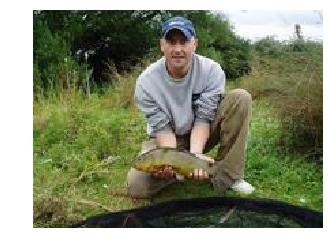

None


In [ ]:
let tensImg = Tensor<UInt8>(cvMat: cvImg)!
let numpyImg = tensImg.makeNumpyArray()
plt.imshow(numpyImg) 
plt.axis("off")
plt.show()

### Grab all the images

Now that we have donloaded the data, we need to be able to recursively grab all the filenames in the imagenette folder. The following function walks recursively through the folder and adds the filenames that have the right extension.

In [ ]:
//export
public func fetchFiles(path: Path, recurse: Bool = false, extensions: [String]? = nil) -> [Path] {
    var res: [Path] = []
    for p in try! path.ls(){
        if p.kind == .directory && recurse { 
            res += fetchFiles(path: p.path, recurse: recurse, extensions: extensions)
        } else if extensions == nil || extensions!.contains(p.path.extension.lowercased()) {
            res.append(p.path)
        }
    }
    return res
}

Note that we don't have a generic `open_image` function like in python here, but will be using a specific decode function (here for jpegs, but there is one for gifs or pngs). That's why we limit ourselves to jpeg exensions here.

In [ ]:
time { let fNames = fetchFiles(path: path, recurse: true, extensions: ["jpeg", "jpg"]) }

average: 1074.471998 ms,   min: 1074.471998 ms,   max: 1074.471998 ms


In [ ]:
let fNames = fetchFiles(path: path, recurse: true, extensions: ["jpeg", "jpg"])

In [ ]:
fNames.count == 13394

true


In [ ]:
print(type(of: cvImg))

Mat


## Prepare the data

In [ ]:
//export
public protocol ItemBase {
    func transform( _ tfms: [(inout Self) -> ()]) -> Self
}

In [ ]:
public struct Image: ItemBase{
    
    public var path: Path
    public lazy var img: Mat = {
        print("Load image in memory")
        return imdecode(try! Data(contentsOf: path.url))
    } ()
    
    public init(_ img: Mat, _ path: Path) {
        (self.path,self.img) = (path,img)
    }
    
    public init(_ path: Path) { self.path = path }
    
    public mutating func show(){
        let tensImg = Tensor<UInt8>(cvMat: img)!
        let numpyImg = tensImg.makeNumpyArray()
        plt.imshow(numpyImg) 
        plt.axis("off")
        plt.show()
    }
    
    public func transform(_ tfms: [(inout Image) -> ()]) -> Image{
        var tfmedImg = Image(path)
        tfms.forEach() { $0(&tfmedImg) }
        return tfmedImg
    }
    
    public mutating func toTensor() -> TF {
        return TF(cvMat: img)!
    }
}

In [ ]:
var img = Image(imgFn)

Load image in memory


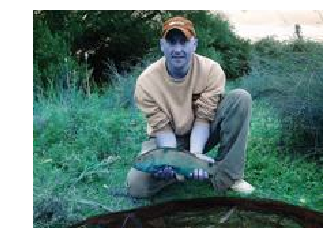

In [ ]:
img.show()

### ItemList

In [ ]:
// export
public struct ItemList<T> where T: ItemBase{
    public var items: [T]
    public let path: Path
    public var tfms: [(inout T) -> ()] = [] 
    
    public init(items: [T], path: Path, tfms: [(inout T) -> ()] = []){
        (self.items,self.path,self.tfms) = (items,path,tfms)
    }
    
    public init (_ il: ItemList<T>, newItems: [T]) {
        self.init(items: newItems, path: il.path, tfms: il.tfms)
    }
    
    public subscript(index: Int) -> T {
        return items[index].transform(tfms)
    }
}

In [ ]:
// export
public protocol InitableFromPath {
    init(_ path: Path)
}
extension Image: InitableFromPath {}

In [ ]:
// export
public extension ItemList where T: InitableFromPath {
    init(fromFolder path: Path, extensions: [String], recurse: Bool = true, tfms: [(inout T) -> ()] = []) {
        self.init(items: fetchFiles(path: path, recurse: recurse, extensions: extensions).map { T($0) },
                  path:  path,
                  tfms: tfms)
    }
}

In [ ]:
let il: ItemList<Image> = ItemList(fromFolder: path, extensions: ["jpeg", "jpg"])

Load image in memory


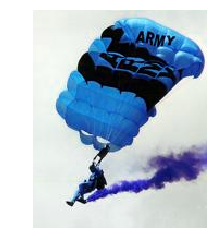

In [ ]:
var img = il[0]
img.show()

In [ ]:
func convertRGB(_ img: inout Image) {
    img.img = cvtColor(img.img, nil, ColorConversionCode.COLOR_BGR2RGB)
}

func resize(_ img: inout Image, size: Int) {
    img.img = resize(img.img, nil, Size(size, size), 0, 0, InterpolationFlag.INTER_AREA)
}

In [ ]:
let il: ItemList<Image> = ItemList(fromFolder: path, extensions: ["jpeg", "jpg"],
                                  tfms: [convertRGB, { resize(&$0, size:128) }])

Load image in memory


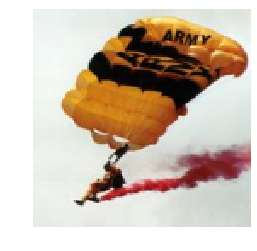

In [ ]:
var img = il[0]
img.show()

### Split

In [ ]:
// export
public struct SplitData<T> where T: ItemBase{
    public let train, valid: ItemList<T>
    public var path: Path { return train.path }
    
    public init(train: ItemList<T>, valid: ItemList<T>){
        (self.train, self.valid) = (train, valid)
    }
    
    public init(_ il: ItemList<T>, fromFunc: (T) -> Bool){
        self.init(train: ItemList(il, newItems: il.items.filter { !fromFunc($0) }),
                  valid: ItemList(il, newItems: il.items.filter {  fromFunc($0) }))
    }
}

In [ ]:
// export
public func grandParentSplitter(fName: Path, valid: String = "valid") -> Bool{
    return fName.parent.parent.basename() == valid
}

In [ ]:
let sd = SplitData(il) { grandParentSplitter(fName: $0.path, valid: "val") }

Load image in memory


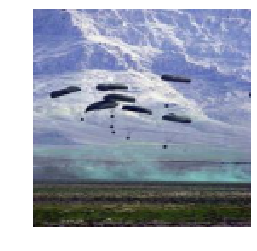

In [ ]:
var img = sd.train[0]
img.show()

### Processor

In [ ]:
// export
public protocol Processor {
    associatedtype Input: ItemBase
    associatedtype Output: ItemBase
    
    mutating func initState(_ items: [Input])
    func process1(_ item: Input) -> Output
    func deprocess1(_ item: Output) -> Input
}

In [ ]:
// export
public extension Processor {
    func process(_ items: [Input]) -> [Output] {
        return items.map { process1($0) }
    }
    
    func deprocess(_ items: [Output]) -> [Input] {
        return items.map { deprocess1($0) }
    }
}

In [ ]:
// export
public struct NoopProcessor<Item>: Processor where Item: ItemBase{
    public init() {}
   
    public mutating func initState(_ items: [Item]) {}
    
    public func process1  (_ item: Item) -> Item { return item }
    public func deprocess1(_ item: Item) -> Item { return item }
}

In [ ]:
//export
extension String: ItemBase {
    public func transform(_ tfms: [(inout String) -> ()]) -> (String) { return self }
}

extension Int: ItemBase {
    public func transform(_ tfms: [(inout Int) -> ()]) -> (Int) { return self }
}

In [ ]:
// export
public struct CategoryProcessor: Processor {
    public init() {}
    public var vocab: [String]? = nil
    public var reverseMap: [String: Int]? = nil
    
    public mutating func initState(_ items: [String]) {
        vocab = Array(Set(items)).sorted()
        reverseMap = [:]
        for (i,x) in vocab!.enumerated() { reverseMap![x] = i }
    }
    
    public func process1  (_ item: String) -> Int { return reverseMap![item]! }
    public func deprocess1(_ item: Int) -> String { return vocab![item] }
}

### Label

When we build the datasets, we don't need to return a tupe (item, label) but to have the tensor(s) with the items and the tensor(s) with the labels separately.

In [ ]:
public struct LabeledItemList<I, L> where I:ItemBase, L: ItemBase{
    public var inputs: ItemList<I>
    public var labels: ItemList<L>
    public var path: Path { return inputs.path }
    
    public init(inputs: ItemList<I>, labels: ItemList<L>) {
        (self.inputs,self.labels) = (inputs,labels)
    }
    
    public subscript(_ i: Int) -> (I, L) {
        return (inputs[i], labels[i])
    }
}

public extension LabeledItemList {
    init(_ il: ItemList<I>, labelWithFunc f: @escaping (I) -> L) {
        self.init(inputs: il, labels: ItemList(items: il.items.map{ f($0) }, path: il.path, tfms: []))
    }
}

In [ ]:
public func parentLabeler(_ fName: Path) -> String { return fName.parent.basename() }

In [ ]:
let ll = LabeledItemList(il, labelWithFunc: { parentLabeler($0.path) })

Load image in memory


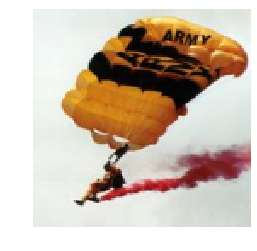

n03888257


In [ ]:
var x = ll[0]
x.0.show()
print(x.1)

In [ ]:
public func process<PI> (_ il: ItemList<PI.Input>, proc: PI) -> ItemList<PI.Output> where PI: Processor {
    return ItemList(items: proc.process(il.items), path: il.path, tfms: [])
}

In [ ]:
public func process<PI, PL> (_ lil: LabeledItemList<PI.Input, PL.Input>, procInp: PI, procLab: PL) 
-> LabeledItemList<PI.Output, PL.Output> where PI: Processor, PL: Processor {
    return LabeledItemList(
        inputs: process(lil.inputs, proc: procInp),
        labels: process(lil.labels, proc: procLab)
    )
}

In [ ]:
public struct SplitLabeledData<PI, PL> where PI: Processor, PL: Processor{
    public var train, valid: LabeledItemList<PI.Output, PL.Output>
    public var path: Path { return train.path }
    public var procInp: PI
    public var procLab: PL
    
    public init(_ rawTrain: LabeledItemList<PI.Input,PL.Input>, 
                _ rawValid: LabeledItemList<PI.Input,PL.Input>,
                procInp: inout PI,
                procLab: inout PL) {
        procInp.initState(rawTrain.inputs.items)
        procLab.initState(rawTrain.labels.items)
        train = process(rawTrain, procInp: procInp, procLab: procLab)
        valid = process(rawValid, procInp: procInp, procLab: procLab)
        (self.procInp,self.procLab) = (procInp,procLab)
    }
}

In [ ]:
public extension SplitLabeledData {
    init(_ sd: SplitData<PI.Input>, 
         labelWithFunc f: @escaping (PI.Input) -> PL.Input,
         procInp: inout PI,
         procLab: inout PL) {
        self.init(LabeledItemList(sd.train, labelWithFunc: f),
                  LabeledItemList(sd.valid, labelWithFunc: f),
                  procInp: &procInp,
                  procLab: &procLab)
    }
}

In [ ]:
var procInp = NoopProcessor<Image>()
var procLab = CategoryProcessor()

In [ ]:
var sld = SplitLabeledData(sd, labelWithFunc: { parentLabeler($0.path) }, procInp: &procInp, procLab: &procLab)

Labeling loses the transforms.

Load image in memory
n03888257


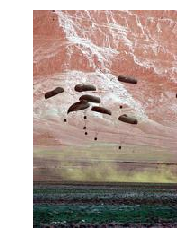

In [ ]:
var x = sld.train[0]
x.0.show()
print(sld.procLab.deprocess1(x.1))

So we add them back

In [ ]:
sld.train.inputs.tfms = [convertRGB, { resize(&$0, size:128) }]

Load image in memory
n03888257


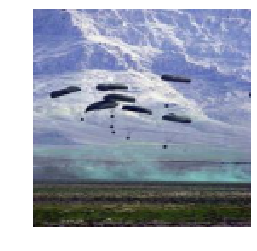

In [ ]:
var x = sld.train[0]
x.0.show()
print(sld.procLab.deprocess1(x.1))

In [ ]:
public extension SplitLabeledData{
    mutating func transform(_ tfms: ([(inout PI.Output) -> ()], [(inout PI.Output) -> ()])){
        train.inputs.tfms = tfms.0
        valid.inputs.tfms = tfms.1
    }
}

In [ ]:
var sld = SplitLabeledData(sd, labelWithFunc: { parentLabeler($0.path) }, procInp: &procInp, procLab: &procLab)
let tfms = [convertRGB, { resize(&$0, size:128) }]
sld = sld.transform((tfms, tfms))

: 

In [ ]:
var x = sld.train[0]
x.0.show()
print(sld.procLab.deprocess1(x.1))

What's below doesn't work with that's above.

### Datasets

To go in a Dataset, our array of items and array of labels need to be converted to tensors.

In [ ]:
// export
public struct LabeledElement<I: TensorGroup, L: TensorGroup>: TensorGroup {
    public var xb: I
    public var yb: L    
    
    public init(xb: I, yb: L) {
        (self.xb, self.yb) = (xb, yb)
    }
}

In [ ]:
// export
public extension SplitLabeledData {
    func toDataBunch<XB, YB> (
        itemToTensor: ([PI.Output]) -> XB, labelToTensor: ([PL.Output]) -> YB, bs: Int = 64
    ) -> DataBunch<LabeledElement<XB, YB>> where XB: TensorGroup, YB: TensorGroup {
        let trainDs = Dataset<LabeledElement<XB, YB>>(
            elements: LabeledElement(xb: itemToTensor(train.items), yb: labelToTensor(train.labels)))
        let validDs = Dataset<LabeledElement<XB, YB>>(
            elements: LabeledElement(xb: itemToTensor(valid.items), yb: labelToTensor(valid.labels)))
        return DataBunch(train: trainDs, 
                         valid: validDs, 
                         trainLen: train.items.count, 
                         validLen: valid.items.count,
                         bs: bs)
    }
}

In [ ]:
// export
public func pathsToTensor(_ paths: [Path]) -> StringTensor { return StringTensor(paths.map{ $0.string })}
public func intsToTensor(_ items: [Int32]) -> Tensor<Int32> { return Tensor<Int32>(items)}

In [ ]:
let dataset = sld.toDataBunch(itemToTensor: pathsToTensor, labelToTensor: intsToTensor)

### Transforms

We directly plug in to the dataset the transforms we want to apply.

In [ ]:
// export
public func transformData<I,TI,L>(
    _ data: DataBunch<LabeledElement<I,L>>, 
    tfmItem: (I) -> TI
) -> DataBunch<DataBatch<TI,L>> 
where I: TensorGroup, TI: TensorGroup & Differentiable, L: TensorGroup{
    return DataBunch(train: data.train.innerDs.map{ DataBatch(xb: tfmItem($0.xb), yb: $0.yb) },
                     valid: data.valid.innerDs.map{ DataBatch(xb: tfmItem($0.xb), yb: $0.yb) },
                     trainLen: data.train.dsCount, 
                     validLen: data.valid.dsCount,
                     bs: data.train.bs)
}

In [ ]:
// export
public func openAndResize(fname: StringTensor, size: Int) -> TF{
    let decodedImg = StringTensor(readFile: fname).decodeJpeg(channels: 3)
    let resizedImg = Tensor<Float>(Raw.resizeNearestNeighbor(
        images: Tensor<UInt8>([decodedImg]), 
        size: Tensor<Int32>([Int32(size), Int32(size)]))) / 255.0
    return resizedImg.reshaped(to: TensorShape(size, size, 3))
}

In [ ]:
let tfmData = transformData(dataset) { openAndResize(fname: $0, size: 128) }

In [ ]:
// export
public extension FADataset {
    func oneBatch() -> Element? {
        for batch in ds { return batch }
        return nil
    }
} 

In [ ]:
let batch = tfmData.train.oneBatch()!
batch.xb.shape

▿ TensorShape
  ▿ dimensions : 4 elements
    - 0 : 64
    - 1 : 128
    - 2 : 128
    - 3 : 3


In [ ]:
// export
public func showImages(_ xb: TF, labels: [String]? = nil) {
    let (rows,cols) = (3,3)
    plt.figure(figsize: [9, 9])
    for i in 0..<(rows * cols) {
        let img = plt.subplot(rows, cols, i + 1)
        img.axis("off")
        let x = xb[i].makeNumpyArray()
        img.imshow(x)
        if labels != nil { img.set_title(labels![i]) }
        if (i + 1) >= (rows * cols) { break }
    }
    plt.show()
}

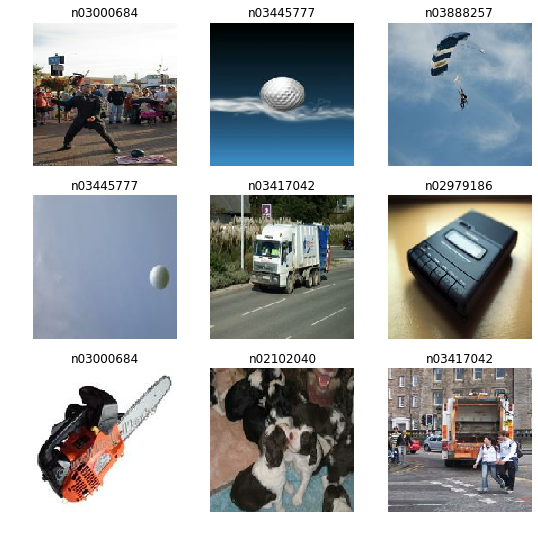

In [ ]:
let labels = batch.yb.scalars.map { sld.train.procLabel.vocab![Int($0)] }
showImages(batch.xb, labels: labels)

### To summarize:

In [ ]:
let il = ItemList(fromFolder: path, extensions: ["jpeg", "jpg"])
let sd = SplitData(il, fromFunc: {grandParentSplitter(fName: $0, valid: "val")})
var (procItem,procLabel) = (NoopProcessor<Path>(), CategoryProcessor())
let sld = SplitLabeledData(sd, fromFunc: parentLabeler, procItem: &procItem, procLabel: &procLabel)
var rawData = sld.toDataBunch(itemToTensor: pathsToTensor, labelToTensor: intsToTensor)
let data = transformData(rawData) { openAndResize(fname: $0, size: 128) }

Let's try to train it:

In [ ]:
//export 
public let imagenetStats = (mean: TF([0.485, 0.456, 0.406]), std: TF([0.229, 0.224, 0.225]))

In [ ]:
//export
public func prevPow2(_ x: Int) -> Int { 
    var res = 1
    while res <= x { res *= 2 }
    return res / 2
}

In [ ]:
//export
public struct CNNModel: Layer {
    public var convs: [ConvBN<Float>]
    public var pool = FAGlobalAvgPool2D<Float>()
    public var linear: FADense<Float>
    
    public init(channelIn: Int, nOut: Int, filters: [Int]){
        convs = []
        let (l1,l2) = (channelIn, prevPow2(channelIn * 9))
        convs = [ConvBN(l1,   l2,   stride: 1),
                 ConvBN(l2,   l2*2, stride: 2),
                 ConvBN(l2*2, l2*4, stride: 2)]
        let allFilters = [l2*4] + filters
        for i in 0..<filters.count { convs.append(ConvBN(allFilters[i], allFilters[i+1], stride: 2)) }
        linear = FADense<Float>(filters.last!, nOut)
    }
    
    @differentiable
    public func call(_ input: TF) -> TF {
        return input.sequenced(through: convs, pool, linear)
    }
}

In [ ]:
func optFunc(_ model: CNNModel) -> SGD<CNNModel> { return SGD(for: model, learningRate: 0.1) }
func modelInit() -> CNNModel { return CNNModel(channelIn: 3, nOut: 10, filters: [64, 64, 128, 256]) }
let learner = Learner(data: data, lossFunc: softmaxCrossEntropy, optFunc: optFunc, modelInit: modelInit)
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.addDelegate(learner.makeNormalize(mean: imagenetStats.mean, std: imagenetStats.std))

In [ ]:
learner.fit(1)

Epoch 0: [1.4235003, 0.512]                                                     


## Export

In [ ]:
import NotebookExport
let exporter = NotebookExport(Path.cwd/"08_data_block.ipynb")
print(exporter.export(usingPrefix: "FastaiNotebook_"))

success
